# ResNet-9 — 3D-Print Defect Detection (Safe FP32, Label Mapping in Dataset)

เวอร์ชันนี้ตั้งค่าให้ **นิ่งก่อน**: ไม่ใช้ AMP, ไม่ใช้ fused op ของ `torchvision.ops.misc`, map labels ภายใน `Dataset`, และมี **preflight** ตรวจ CPU/GPU forward ก่อนเข้าเทรน

> หลังรันจบและนิ่งแล้ว ค่อยเปิด AMP/pin_memory/non_blocking และ cuDNN ทีละอย่างภายหลังได้

In [1]:
pip install numpy pandas pillow torch torchvision scikit-learn matplotlib tqdm


Note: you may need to restart the kernel to use updated packages.


In [2]:
# ต้องรันเซลล์นี้ก่อน import torch เพื่อให้ traceback ชี้บรรทัดจริงเวลามีเคอร์เนลพัง
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [3]:
import os, random
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import GroupShuffleSplit, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn

# reproducibility
SEED = 1337
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [4]:
IN_COLAB = False
try:
    from google.colab import drive  # type: ignore
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    drive.mount('/content/drive')
    ROOT = Path("/content/drive/MyDrive/Colab Notebooks/CNN-detect 3dprint-fail")
else:
    # 🖥️ บนเครื่อง (แก้ path ให้ตรงกับโฟลเดอร์โปรเจกต์คุณ)
    ROOT = Path(r"/home/a/rocm_env/bin/Printing_Errors")

IMAGES_ROOT  = ROOT / "images"                 
TRAIN_SUBDIR = "all_images256"                 
CSV_MASTER   = ROOT / "general_data" / "all_images_no_filter.csv"
SPLIT_DIR    = ROOT / "splits"
SPLIT_DIR.mkdir(parents=True, exist_ok=True)

CLASS_RAW    = [0,1,2,4]
RAW2IDX      = {r:i for i, r in enumerate(CLASS_RAW)}
IDX2RAW      = {i:r for r,i in RAW2IDX.items()}
NUM_CLASSES  = len(CLASS_RAW)

print("ROOT:", ROOT)
print("IMAGES_ROOT exists:", IMAGES_ROOT.exists())
print("CSV_MASTER exists:", CSV_MASTER.exists())

ROOT: /home/a/rocm_env/bin/Printing_Errors
IMAGES_ROOT exists: True
CSV_MASTER exists: True


In [5]:
# --- โหลด CSV (auto delimiter) ---
df_master = pd.read_csv(CSV_MASTER, sep=None, engine='python', encoding='utf-8')
df_master.columns = [c.strip() for c in df_master.columns]
assert {"image","class"}.issubset(df_master.columns), "CSV must include 'image' and 'class'"

# เฉพาะคลาสที่ใช้
df_master = df_master[df_master["class"].isin(CLASS_RAW)].copy()

# normalize path
df_master["image"] = df_master["image"].astype(str).str.strip().str.replace("\\", "/", regex=False)

def ensure_subdir_path(s: str) -> str:
    return s if "/" in s else f"{TRAIN_SUBDIR}/{s}"
df_master["image"] = df_master["image"].apply(ensure_subdir_path)

# เก็บเฉพาะที่อยู่ในโดเมน train_subdir
df_master = df_master[df_master["image"].str.startswith(f"{TRAIN_SUBDIR}/", na=False)].reset_index(drop=True)

# เก็บเฉพาะไฟล์ที่มีจริง
def exists_image(rel: str) -> bool:
    return (IMAGES_ROOT / rel).exists()
df_master = df_master[df_master["image"].apply(exists_image)].reset_index(drop=True)
print("Total images (train domain & exists):", len(df_master))

# --- Split Train and Test ---
def split_train_test(df, group_col="recording", test_size=0.30, seed=42):
    if group_col in df.columns and df[group_col].notna().any():
        groups = df[group_col].fillna("nogroup")
        gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
        i_tr, i_te = next(gss.split(df, groups=groups))
        return df.iloc[i_tr].copy(), df.iloc[i_te].copy()
    else:
        y = df["class"]
        sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
        i_tr, i_te = next(sss.split(df, y))
        return df.iloc[i_tr].copy(), df.iloc[i_te].copy()

# Split into train and test sets
df_tr, df_te = split_train_test(df_master, group_col="recording", test_size=0.30, seed=42)

# Save the split data
df_tr.to_csv(SPLIT_DIR/"train.csv", index=False)
df_te.to_csv(SPLIT_DIR/"test.csv", index=False)

# --- Display class distribution in Train and Test sets ---
print("Split sizes -> Train:", len(df_tr), " Test:", len(df_te))

# Show class distribution in the training set
print("\nClass distribution in training set:")
print(df_tr["class"].value_counts())

# Show class distribution in the testing set
print("\nClass distribution in testing set:")
print(df_te["class"].value_counts())


Total images (train domain & exists): 16287
Split sizes -> Train: 11456  Test: 4831

Class distribution in training set:
class
0    5133
1    3184
2    2977
4     162
Name: count, dtype: int64

Class distribution in testing set:
class
1    2328
0    1893
2     532
4      78
Name: count, dtype: int64


In [6]:
# --- Dataset พร้อม map label ภายใน ---
class CustomImageDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.root_dir = Path(root_dir)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        p = self.root_dir / self.df.loc[idx, "image"]
        y_raw = int(self.df.loc[idx, "class"])  # 0,1,2,4
        y = RAW2IDX[y_raw]                       # 0..3
        x = Image.open(p).convert("RGB")
        if self.transform: 
            x = self.transform(x)
        return x, y

transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

ds_train = CustomImageDataset(df_tr, IMAGES_ROOT, transform)
ds_test  = CustomImageDataset(df_te, IMAGES_ROOT, transform)

BATCH = 64
# ⚡ CPU friendly DataLoader (no pin_memory, no persistent_workers)
train_ld = DataLoader(ds_train, batch_size=BATCH, shuffle=True,
                      num_workers=4, pin_memory=True, persistent_workers=True)
test_ld  = DataLoader(ds_test,  batch_size=BATCH, shuffle=False,
                      num_workers=4, pin_memory=True, persistent_workers=True)

# Sanity batch
xb, yb = next(iter(train_ld))
print("Batch:", xb.shape, xb.dtype, "targets:", int(yb.min()), "->", int(yb.max()))


Batch: torch.Size([64, 3, 256, 256]) torch.float32 targets: 0 -> 3


In [7]:
# --- ResNet-9 (Conv+BN+ReLU ธรรมดา; ไม่มี fused ops) ---
def conv_bn_relu(in_c, out_c, k=3, s=1, p=1):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=k, stride=s, padding=p, bias=False),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=False),
    )

class BasicBlock(nn.Module):
    def __init__(self, c):
        super().__init__()
        self.conv1 = conv_bn_relu(c, c)
        self.conv2 = nn.Sequential(
            nn.Conv2d(c, c, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(c),
        )
        self.relu = nn.ReLU(inplace=False)
    def forward(self, x):
        id = x
        x = self.conv1(x)
        x = self.conv2(x)
        x = x + id
        return self.relu(x)

class ResNet9(nn.Module):
    def __init__(self, in_ch=3, num_classes=NUM_CLASSES):
        super().__init__()
        self.layer1 = conv_bn_relu(in_ch, 64, 3, 1, 1)
        self.layer2 = conv_bn_relu(64, 128, 3, 2, 1)
        self.res1   = BasicBlock(128)
        self.layer3 = conv_bn_relu(128, 256, 3, 2, 1)
        self.layer4 = conv_bn_relu(256, 512, 3, 2, 1)
        self.res2   = BasicBlock(512)
        self.pool   = nn.AdaptiveAvgPool2d(1)
        self.fc     = nn.Linear(512, NUM_CLASSES)
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x); x = self.res1(x)
        x = self.layer3(x)
        x = self.layer4(x); x = self.res2(x)
        x = self.pool(x).flatten(1)
        return self.fc(x)

model = ResNet9().float().to(device)
print(model.__class__.__name__, "on", device)

ResNet9 on cuda


In [8]:
# --- Preflight: CPU แล้ว GPU FP32 ---
m_cpu = ResNet9().float().cpu().eval()
with torch.no_grad():
    _ = m_cpu(xb.float())
print("[CPU] forward OK")

cudnn.enabled = False; cudnn.benchmark = False; cudnn.deterministic = True
m_gpu = ResNet9().float().to(device).eval()
with torch.no_grad():
    _ = m_gpu(xb.float().to(device))
print("[GPU] forward OK (FP32, no AMP, no cuDNN)")

[CPU] forward OK
[GPU] forward OK (FP32, no AMP, no cuDNN)


In [9]:
print("len(ds_train) =", len(ds_train), " | len(train_ld) (batches) =", len(train_ld))
# ดูตัวอย่างไฟล์ 3 รายการแรก
for i in range(min(3, len(ds_train))):
    p = IMAGES_ROOT / ds_train.df.loc[i, "image"]
    print(f"[{i}] exists={p.exists()}  ->", p)

# ลองดึง batch แรก (จะรู้เลยว่าติดตรงนี้ไหม)
xb, yb = next(iter(train_ld))
print("First batch OK:", xb.shape, yb.shape, yb.min().item(), yb.max().item())


len(ds_train) = 11456  | len(train_ld) (batches) = 179
[0] exists=True  -> /home/a/rocm_env/bin/Printing_Errors/images/all_images256/ELP_12MP_01.12.2022_166990882982.png
[1] exists=True  -> /home/a/rocm_env/bin/Printing_Errors/images/all_images256/ELP_12MP_01.12.2022_166990882986.png
[2] exists=True  -> /home/a/rocm_env/bin/Printing_Errors/images/all_images256/ELP_12MP_01.12.2022_166990887746.png
First batch OK: torch.Size([64, 3, 256, 256]) torch.Size([64]) 0 2


In [ ]:
# ========= FAST TRAIN LOOP =========
from tqdm.auto import tqdm
import torch.backends.cudnn as cudnn

EPOCHS = 30
BATCH  = 32   # เพิ่ม batch ให้ใหญ่ขึ้นถ้า VRAM พอ

USE_FOCAL = True
FOCAL_GAMMA = 2.0  # ค่ามาตรฐานที่นิยม: 1.5–2.5


criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)

# เปิด cuDNN ให้ optimize
cudnn.enabled = True
cudnn.benchmark = True

# เปิด Automatic Mixed Precision (AMP)
USE_AMP = True
scaler = torch.amp.GradScaler("cuda", enabled=USE_AMP)

for ep in range(1, EPOCHS+1):
    model.train()
    total = correct = 0
    run_loss = 0.0

    pbar = tqdm(train_ld, desc=f"Epoch {ep}/{EPOCHS}", unit="batch", leave=True)
    for x, y in pbar:
        # ส่งขึ้น GPU (non_blocking=True ช่วยให้เร็วขึ้นตอน pin_memory=True)
        x = x.to(device, non_blocking=True)
        y = torch.as_tensor(y, dtype=torch.long, device=device)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast("cuda", enabled=USE_AMP):
            logits = model(x)
            loss   = criterion(logits, y)

        # backward + optimizer step
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()

        # metrics
        bs = x.size(0)
        run_loss += loss.item() * bs
        total    += bs
        correct  += (logits.argmax(1) == y).sum().item()

        # update progress bar
        pbar.set_postfix({
            "loss": f"{run_loss/total:.4f}",
            "acc":  f"{correct/total:.3f}"
        })

    print(f"[Epoch {ep:02d}] loss {run_loss/total:.4f}  acc {correct/total:.3f}")

print("Training done ✅")


/home/a/rocm_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Epoch 1/30: 100%|██████████| 179/179 [03:59<00:00,  1.34s/batch, loss=0.6387, acc=0.725] 


[Epoch 01] loss 0.6387  acc 0.725


Epoch 2/30: 100%|██████████| 179/179 [00:47<00:00,  3.80batch/s, loss=0.3901, acc=0.846]


[Epoch 02] loss 0.3901  acc 0.846


Epoch 3/30: 100%|██████████| 179/179 [00:47<00:00,  3.81batch/s, loss=0.2753, acc=0.892]


[Epoch 03] loss 0.2753  acc 0.892


Epoch 4/30: 100%|██████████| 179/179 [00:47<00:00,  3.81batch/s, loss=0.2135, acc=0.919]


[Epoch 04] loss 0.2135  acc 0.919


Epoch 5/30: 100%|██████████| 179/179 [00:46<00:00,  3.81batch/s, loss=0.1557, acc=0.942]


[Epoch 05] loss 0.1557  acc 0.942


Epoch 6/30: 100%|██████████| 179/179 [00:46<00:00,  3.82batch/s, loss=0.1114, acc=0.961]


[Epoch 06] loss 0.1114  acc 0.961


Epoch 7/30: 100%|██████████| 179/179 [00:46<00:00,  3.82batch/s, loss=0.0966, acc=0.965]


[Epoch 07] loss 0.0966  acc 0.965


Epoch 8/30: 100%|██████████| 179/179 [00:46<00:00,  3.82batch/s, loss=0.0777, acc=0.973]


[Epoch 08] loss 0.0777  acc 0.973


Epoch 9/30: 100%|██████████| 179/179 [00:46<00:00,  3.82batch/s, loss=0.0586, acc=0.980]


[Epoch 09] loss 0.0586  acc 0.980


Epoch 10/30: 100%|██████████| 179/179 [00:46<00:00,  3.82batch/s, loss=0.0571, acc=0.981]


[Epoch 10] loss 0.0571  acc 0.981


Epoch 11/30: 100%|██████████| 179/179 [00:46<00:00,  3.82batch/s, loss=0.0502, acc=0.984]


[Epoch 11] loss 0.0502  acc 0.984


Epoch 12/30: 100%|██████████| 179/179 [00:46<00:00,  3.82batch/s, loss=0.0470, acc=0.984]


[Epoch 12] loss 0.0470  acc 0.984


Epoch 13/30: 100%|██████████| 179/179 [00:46<00:00,  3.82batch/s, loss=0.0391, acc=0.988]


[Epoch 13] loss 0.0391  acc 0.988


Epoch 14/30: 100%|██████████| 179/179 [00:46<00:00,  3.83batch/s, loss=0.0341, acc=0.989]


[Epoch 14] loss 0.0341  acc 0.989


Epoch 15/30: 100%|██████████| 179/179 [00:46<00:00,  3.82batch/s, loss=0.0328, acc=0.988]


[Epoch 15] loss 0.0328  acc 0.988


Epoch 16/30: 100%|██████████| 179/179 [00:46<00:00,  3.83batch/s, loss=0.0328, acc=0.988]


[Epoch 16] loss 0.0328  acc 0.988


Epoch 17/30: 100%|██████████| 179/179 [00:46<00:00,  3.83batch/s, loss=0.0211, acc=0.993]


[Epoch 17] loss 0.0211  acc 0.993


Epoch 18/30: 100%|██████████| 179/179 [00:46<00:00,  3.83batch/s, loss=0.0245, acc=0.993]


[Epoch 18] loss 0.0245  acc 0.993


Epoch 19/30: 100%|██████████| 179/179 [00:46<00:00,  3.83batch/s, loss=0.0228, acc=0.992]


[Epoch 19] loss 0.0228  acc 0.992


Epoch 20/30: 100%|██████████| 179/179 [00:46<00:00,  3.83batch/s, loss=0.0191, acc=0.993]


[Epoch 20] loss 0.0191  acc 0.993


Epoch 21/30: 100%|██████████| 179/179 [00:46<00:00,  3.82batch/s, loss=0.0161, acc=0.995]


[Epoch 21] loss 0.0161  acc 0.995


Epoch 22/30: 100%|██████████| 179/179 [00:46<00:00,  3.83batch/s, loss=0.0189, acc=0.993]


[Epoch 22] loss 0.0189  acc 0.993


Epoch 23/30: 100%|██████████| 179/179 [00:46<00:00,  3.83batch/s, loss=0.0175, acc=0.994]


[Epoch 23] loss 0.0175  acc 0.994


Epoch 24/30: 100%|██████████| 179/179 [00:46<00:00,  3.83batch/s, loss=0.0170, acc=0.994]


[Epoch 24] loss 0.0170  acc 0.994


Epoch 25/30: 100%|██████████| 179/179 [00:46<00:00,  3.83batch/s, loss=0.0155, acc=0.995]


[Epoch 25] loss 0.0155  acc 0.995


Epoch 26/30: 100%|██████████| 179/179 [00:46<00:00,  3.83batch/s, loss=0.0143, acc=0.995]


[Epoch 26] loss 0.0143  acc 0.995


Epoch 27/30: 100%|██████████| 179/179 [00:46<00:00,  3.83batch/s, loss=0.0096, acc=0.997]


[Epoch 27] loss 0.0096  acc 0.997


Epoch 28/30: 100%|██████████| 179/179 [00:46<00:00,  3.84batch/s, loss=0.0038, acc=0.999]


[Epoch 28] loss 0.0038  acc 0.999


Epoch 29/30: 100%|██████████| 179/179 [00:46<00:00,  3.83batch/s, loss=0.0059, acc=0.998]


[Epoch 29] loss 0.0059  acc 0.998


Epoch 30/30: 100%|██████████| 179/179 [00:46<00:00,  3.83batch/s, loss=0.0076, acc=0.998]

[Epoch 30] loss 0.0076  acc 0.998
Training done ✅



=== TEST SCORES ===
Accuracy               : 0.6566
Balanced Accuracy      : 0.5330
Top-2 Accuracy         : 0.8154
Log Loss               : 2.8935
MCC                    : 0.4920
Cohen's Kappa          : 0.4649
Precision (micro/macro/weighted): 0.6566 / 0.5877 / 0.7826
Recall    (micro/macro/weighted): 0.6566 / 0.5330 / 0.6566
F1        (micro/macro/weighted): 0.6566 / 0.5169 / 0.6811

--- Classification report (per class) ---
              precision    recall  f1-score   support

           0       0.88      0.41      0.56      1893
           1       0.75      0.88      0.81      2328
           2       0.70      0.63      0.66       532
           4       0.02      0.22      0.04        78

    accuracy                           0.66      4831
   macro avg       0.59      0.53      0.52      4831
weighted avg       0.78      0.66      0.68      4831



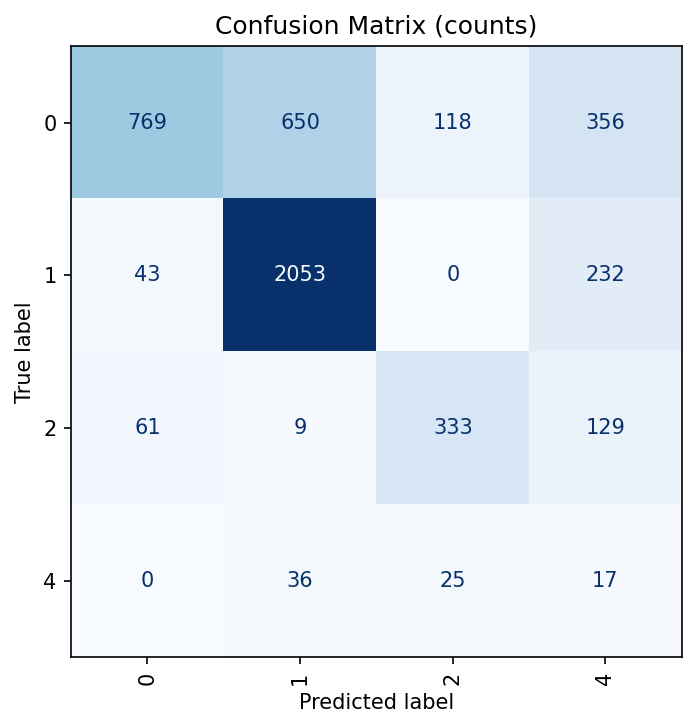

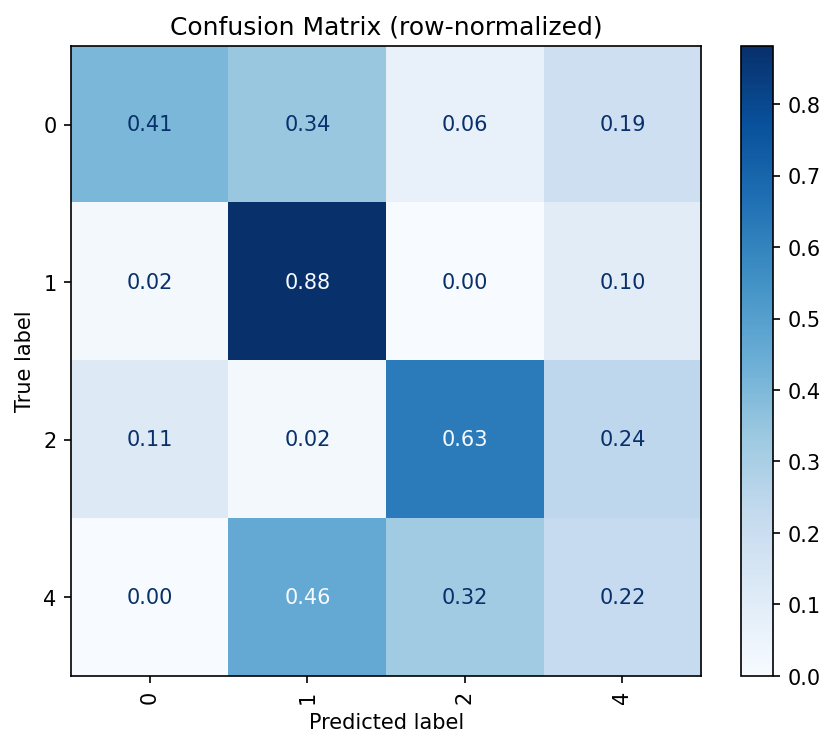

In [11]:
# ========= Evaluate + Metrics + Confusion Matrix =========
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_recall_fscore_support,
    classification_report, matthews_corrcoef, cohen_kappa_score,
    confusion_matrix, ConfusionMatrixDisplay, log_loss, top_k_accuracy_score
)
import torch.nn.functional as F

model.eval()
y_true, y_pred = [], []
all_probs = []

with torch.inference_mode():
    for x, y in test_ld:
        x = x.to(device)
        logits = model(x)
        probs  = F.softmax(logits, dim=1).cpu().numpy()
        all_probs.append(probs)

        y_true.extend(torch.as_tensor(y).tolist())
        y_pred.extend(logits.argmax(1).cpu().tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
probs  = np.concatenate(all_probs, axis=0)  # shape: [N, NUM_CLASSES]

# --- Core scores ---
acc      = accuracy_score(y_true, y_pred)
bal_acc  = balanced_accuracy_score(y_true, y_pred)
mcc      = matthews_corrcoef(y_true, y_pred)
kappa    = cohen_kappa_score(y_true, y_pred)
top2_acc = top_k_accuracy_score(y_true, probs, k=2, labels=list(range(NUM_CLASSES)))
lloss    = log_loss(y_true, probs, labels=list(range(NUM_CLASSES)))

# --- PRF (average หลายแบบ) ---
prec_micro, rec_micro, f1_micro, _ = precision_recall_fscore_support(
    y_true, y_pred, average="micro", zero_division=0
)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average="macro", zero_division=0
)
prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(
    y_true, y_pred, average="weighted", zero_division=0
)

print(f"\n=== TEST SCORES ===")
print(f"Accuracy               : {acc:.4f}")
print(f"Balanced Accuracy      : {bal_acc:.4f}")
print(f"Top-2 Accuracy         : {top2_acc:.4f}")
print(f"Log Loss               : {lloss:.4f}")
print(f"MCC                    : {mcc:.4f}")
print(f"Cohen's Kappa          : {kappa:.4f}")
print(f"Precision (micro/macro/weighted): {prec_micro:.4f} / {prec_macro:.4f} / {prec_w:.4f}")
print(f"Recall    (micro/macro/weighted): {rec_micro:.4f} / {rec_macro:.4f} / {rec_w:.4f}")
print(f"F1        (micro/macro/weighted): {f1_micro:.4f} / {f1_macro:.4f} / {f1_w:.4f}")

# --- รายงานรายคลาส ---
labels_vis = [str(IDX2RAW[i]) for i in range(NUM_CLASSES)]
print("\n--- Classification report (per class) ---")
print(classification_report(y_true, y_pred, labels=list(range(NUM_CLASSES)),
                            target_names=labels_vis, zero_division=0))

# --- Confusion matrices ---
cm = confusion_matrix(y_true, y_pred, labels=list(range(NUM_CLASSES)))

fig, ax = plt.subplots(figsize=(6,5), dpi=150)
ConfusionMatrixDisplay(cm, display_labels=labels_vis).plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
plt.title("Confusion Matrix (counts)"); plt.tight_layout()
plt.setp(ax.get_xticklabels(), rotation=90); plt.show()

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
fig, ax = plt.subplots(figsize=(6,5), dpi=150)
ConfusionMatrixDisplay(cm_norm, display_labels=labels_vis).plot(ax=ax, cmap="Blues", values_format=".2f", colorbar=True)
plt.title("Confusion Matrix (row-normalized)"); plt.tight_layout()
plt.setp(ax.get_xticklabels(), rotation=90); plt.show()

# (ออปชัน) เซฟรายงานรายคลาสเป็น CSV
per_class = precision_recall_fscore_support(y_true, y_pred,
                                            labels=list(range(NUM_CLASSES)),
                                            zero_division=0)
df_report = pd.DataFrame({
    "class_raw": labels_vis,
    "precision": per_class[0],
    "recall":    per_class[1],
    "f1":        per_class[2],
    "support":   per_class[3]
})
# df_report.to_csv("per_class_report.csv", index=False)
